In [ ]:
from astropy.io import fits
import astropy.wcs as wcs
import astropy.units as u
from astropy.convolution import convolve_fft
from astropy.stats import mad_std
import numpy as np
from radio_beam import Beam
from reproject import reproject_interp
from matplotlib import pyplot as plt
from scipy.ndimage import binary_dilation
from astropy.modeling import models, fitting
from astropy.table import Table, vstack 
from glob import glob 
from synphot import SpectralElement, units
from matplotlib.ticker import (MultipleLocator)
import os

import warnings 
warnings.filterwarnings('ignore')

# Loading files

In [ ]:
def get_hdu(rootdir, filename, hdu_id=0, return_filename=False):
    filename_full = glob(rootdir+filename)[0]
    if hdu_id == 'all':
        hdu = fits.open(filename_full)
    else:
        hdu = fits.open(filename_full)[hdu_id]
    print(filename_full)

    if return_filename: 
        return(hdu, filename_full)
    else:  
        return(hdu)

galaxy = 'ngc628c'
galaxy_muse = 'ngc0628'
rootdir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/%s/' %galaxy
rootdir_bp = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/' 

narrowband_filter = 'f658n'
instrument_f555w  = 'acs'
instrument_f65Xn = 'acs'
instrument_f814w = 'acs'

hdu_muse_f555w  = get_hdu(rootdir, 'muse/%s*_%s_*F555W.fits' %(galaxy_muse.upper(), instrument_f555w.upper()))
hdu_muse_f65Xn  = get_hdu(rootdir, 'muse/%s*_%s_*%s.fits' %(galaxy_muse.upper(), instrument_f65Xn.upper(), narrowband_filter.upper()))
hdu_muse_f814w  = get_hdu(rootdir, 'muse/%s*_%s_*F814W.fits' %(galaxy_muse.upper(), instrument_f814w.upper()))
hdu_muse_stars  = get_hdu(rootdir, 'muse/%s_starmask.fits' %galaxy_muse.upper())
hdu_muse_neb    = get_hdu(rootdir, 'muse/%s_nebmask.fits' %galaxy_muse.upper())
hdu_muse        = get_hdu(rootdir, 'muse/%s*_MAPS.fits' %galaxy_muse.upper(), 'all')

hdu_hst_f555w   = get_hdu(rootdir, 'hst/%s*_%s_*f555w*.fits' %(galaxy, instrument_f555w))
hdu_hst_f65Xn   = get_hdu(rootdir, 'hst/%s*_%s_*%s*.fits' %(galaxy, instrument_f65Xn, narrowband_filter))
hdu_hst_f814w   = get_hdu(rootdir, 'hst/%s*_%s_*f814w*.fits' %(galaxy, instrument_f814w))

hst_res  = 0.07 * u.arcsec
_, file_muse_f65Xn = get_hdu(rootdir, 'muse/%s*_%s_*%s.fits' %(galaxy_muse.upper(), instrument_f65Xn.upper(), narrowband_filter.upper()), return_filename=True)
muse_res = np.float32(file_muse_f65Xn.split('asec')[0].split('-')[-1]) * u.arcsec

In [ ]:
def make_paths(rootdir):
    
    print('[Info] Outputing to the following:')
    print(rootdir+'hst_contsub_bintests')

    if not os.path.isdir(rootdir+'hst_contsub_bintests'):
        os.mkdir(rootdir+'hst_contsub_bintests')  
    if not os.path.isdir(rootdir+'hst_contsub_bintests/figs'):
        os.mkdir(rootdir+'hst_contsub_bintests/figs')
    os.system('rm -rf '+rootdir+'hst_contsub_bintests/*.fits')

make_paths(rootdir)

In [ ]:
def get_bandpassinfo(files):

    files.sort()

    bp = {}
    for file in files:

        print(file)

        area = 45238.93416 * units.AREA  # HST
        bp_ = SpectralElement.from_file(file)
        name = file.split('/')[-1].split('.dat')[0].replace('HST_', '').replace('.F', '_F')
        name = name.replace('WFC_', '')
        name = name.replace('WFC3_', '')
        name = name.replace('UVIS1', 'UVIS')

        bp[name] = {'equivwidth': bp_.equivwidth().value, 
                    'integrate': bp_.integrate().value, 
                    'rmswidth': bp_.rmswidth().value, 
                    'photbw': bp_.photbw().value, 
                    'fwhm': bp_.fwhm().value, 
                    'rectwidth': bp_.rectwidth().value, 
                    'pivot': bp_.pivot().value, 
                    'unit_response': bp_.unit_response(area).value}  
    
    return(bp)

files_bp = glob('%s*.dat' %rootdir_bp)
bp = get_bandpassinfo(files_bp)
bp.keys()

# Correct units 
HST -> electron/s to ergcm2sA 
MUSE - > Jy to ergcm2sA

In [ ]:
def get_nanzeros(hdu):
    hdu.data[hdu.data == 0] = np.nan
    return(hdu)

hdu_hst_f555w = get_nanzeros(hdu_hst_f555w)
hdu_hst_f65Xn = get_nanzeros(hdu_hst_f65Xn)
hdu_hst_f814w = get_nanzeros(hdu_hst_f814w)

In [ ]:
def get_electrons_2_ergcm2sA(hdu, photflam=None, photplam=None, photbw=None):

    data = hdu.data.copy()

    if photflam == None: 

        # Get the necessary header keywords for scaling and conversion
        photflam = hdu.header['PHOTFLAM']
        photplam = hdu.header['PHOTPLAM']
        photbw = hdu.header['PHOTBW']
    
    # Scale the data using photflam and photbw
    data_conv = data * photflam

    hdu.data = np.array(data_conv, dtype=np.float32) *1e20
    hdu.header['BUNIT'] = ('erg/s/cm2/A/pixel', '1e-20 erg/s/cm2/A')

    return(hdu)

hdu_hst_f555w = get_electrons_2_ergcm2sA(hdu_hst_f555w, bp['%s_%s' %(instrument_f555w.upper(), 'F555W')]['unit_response'])
hdu_hst_f65Xn = get_electrons_2_ergcm2sA(hdu_hst_f65Xn, bp['%s_%s' %(instrument_f65Xn.upper(), narrowband_filter.upper())]['unit_response'])
hdu_hst_f814w = get_electrons_2_ergcm2sA(hdu_hst_f814w, bp['%s_%s' %(instrument_f814w.upper(), 'F814W')]['unit_response'])

In [ ]:
def get_Jy_2_ergcm2sA(hdu, photplam):

    data = hdu.data.copy()
    
    w = photplam * u.AA
    a = 1. * u.Jy
    b = a.to(u.erg / u.cm**2 / u.s / u.AA, u.spectral_density(w))
    data_conv = data * b.value

    hdu.data = np.array(data_conv, dtype=np.float32) *1e20
    hdu.header['BUNIT'] = ('erg/s/cm2/A/pixel', '1e-20 erg/s/cm2/A')

    return(hdu)

hdu_muse_f555w = get_Jy_2_ergcm2sA(hdu_muse_f555w, bp['%s_%s' %(instrument_f555w.upper(), 'F555W')]['pivot'])
hdu_muse_f65Xn = get_Jy_2_ergcm2sA(hdu_muse_f65Xn, bp['%s_%s' %(instrument_f65Xn.upper(), narrowband_filter.upper())]['pivot'])
hdu_muse_f814w = get_Jy_2_ergcm2sA(hdu_muse_f814w, bp['%s_%s' %(instrument_f814w.upper(), 'F814W')]['pivot'])

# Smoothing and Regridding
Smoothing and regridding HST to MUSE 

In [9]:
def get_smooth(hdu, initial_resolution, desired_resolution):
    
    # Create a WCS object from the input HDU header
    wcs_ = wcs.WCS(hdu.header)

    # Calculate the pixel scale in degrees
    pixscale = wcs.utils.proj_plane_pixel_area(wcs_.celestial) ** 0.5 * u.deg
    print(f"[INFO] Pixel scale: {pixscale.to('arcsec'):.2f} arcsec")

    # Define the initial and desired beams
    initial_beam = Beam(initial_resolution)
    desired_beam = Beam(desired_resolution)

    print(f"[INFO] Initial Resolution: {initial_resolution.to('arcsec'):.2f} arcsec")
    print(f"[INFO] Desired Resolution: {desired_resolution.to('arcsec'):.2f} arcsec")
    
    # Create the convolution kernel
    convolution_beam = (desired_resolution.to('arcsec')**2 - initial_resolution.to('arcsec')**2)**0.5
    convolution_kernel = desired_beam.deconvolve(initial_beam).as_kernel(pixscale)
    print(f"[INFO] Convolution kernel: {convolution_beam.to('arcsec'):.2f} arcsec")

    # Convolve the image with the kernel to smooth it
    print("[INFO] Performing image convolution...")
    smoothed_data = convolve_fft(hdu.data, convolution_kernel, preserve_nan=True, allow_huge=True)
    print("[INFO] Image convolution complete.")

    output_hdu = fits.PrimaryHDU(np.array(smoothed_data, dtype=np.float32), hdu.header)

    print("[INFO] Smoothing process completed.")
    return(output_hdu)

hdu_hst_f555w_sm = get_smooth(hdu_hst_f555w, hst_res, muse_res)
hdu_hst_f65Xn_sm = get_smooth(hdu_hst_f65Xn, hst_res, muse_res)
hdu_hst_f814w_sm = get_smooth(hdu_hst_f814w, hst_res, muse_res)

[INFO] Image convolution complete.
[INFO] Smoothing process completed.
[INFO] Pixel scale: 0.04 arcsec arcsec
[INFO] Initial Resolution: 0.07 arcsec arcsec
[INFO] Desired Resolution: 0.92 arcsec arcsec
[INFO] Convolution kernel: 0.92 arcsec arcsec
[INFO] Performing image convolution...
[INFO] Image convolution complete.
[INFO] Smoothing process completed.


In [10]:
def get_regrid(hdu_input, hdu_template, output_filename=None, conserve_flux=True, order='bilinear'):

    print("[INFO] Reprojecting the input image to match the template WCS...")

    # Extract the WCS information from the input and template headers
    wcs_input = wcs.WCS(hdu_input.header)
    wcs_template = wcs.WCS(hdu_template.header)

    # Calculate the pixel scale for input and template images
    pixscale_input = wcs.utils.proj_plane_pixel_area(wcs_input.celestial)
    pixscale_template = wcs.utils.proj_plane_pixel_area(wcs_template.celestial)

    # Reproject the input image to match the template WCS
    print("[INFO] Performing image reprojection...")
    # data_output = reproject_interp(hdu_input, hdu_template.header, order=0, parallel=True)[0]
    # data_output = reproject_interp(hdu_input, hdu_template.header, order=0)[0]
    data_output = reproject_interp(hdu_input, hdu_template.header, order=order)[0]
    hdu_output = fits.PrimaryHDU(data_output, hdu_template.header)
    print("[INFO] Image reprojection complete.")

    if conserve_flux:
        # Scale the output data to conserve flux 
        print(f"[INFO] Scaling the output data to conserve flux with factor {(pixscale_template / pixscale_input):.2f}")
        hdu_output.data = hdu_output.data * (pixscale_template / pixscale_input)
        hdu_output.data = np.array(hdu_output.data, dtype=np.float32)
        print("[INFO] Flux scaling complete.")

    print("[INFO] Reprojection process completed.")
    return(hdu_output)

hdu_hst_f555w_smre = get_regrid(hdu_hst_f555w_sm, hdu_muse_f555w)
hdu_hst_f65Xn_smre = get_regrid(hdu_hst_f65Xn_sm, hdu_muse_f65Xn)
hdu_hst_f814w_smre = get_regrid(hdu_hst_f814w_sm, hdu_muse_f814w)

[INFO] Reprojecting the input image to match the template WCS...
[INFO] Performing image reprojection...
[INFO] Image reprojection complete.
[INFO] Scaling the output data to conserve flux with factor 25.48
[INFO] Flux scaling complete.
[INFO] Reprojection process completed.
[INFO] Reprojecting the input image to match the template WCS...
[INFO] Performing image reprojection...
[INFO] Image reprojection complete.
[INFO] Scaling the output data to conserve flux with factor 25.48
[INFO] Flux scaling complete.
[INFO] Reprojection process completed.
[INFO] Reprojecting the input image to match the template WCS...
[INFO] Performing image reprojection...
[INFO] Image reprojection complete.
[INFO] Scaling the output data to conserve flux with factor 25.48
[INFO] Flux scaling complete.
[INFO] Reprojection process completed.


# Flux scaling
Scaling flux of HST to MUSE with linear fits

In [23]:
def get_bins(data1, data2, num_bins, min_val=None, max_val=None, equal_spaced=True):

    # Calculate min and max if not provided
    if min_val is None:
        min_val = np.nanmin(data1)
    if max_val is None:
        max_val = np.nanmax(data1)

    # Generate bin edges
    # for equal_spaced bins = space spacing
    if equal_spaced:
        bin_edges = np.linspace(min_val, max_val, num_bins + 1)
    # for equal_number bins = same number of points
    else: 
        percentiles = np.linspace(0, 100, num_bins+1)
        bin_edges = np.percentile(data1, percentiles)

    # Calculate mean values within each bin
    binned_values1 = np.zeros(num_bins)
    binned_values2 = np.zeros(num_bins)

    for i in range(num_bins):

        bin_mask = ((data1>=bin_edges[i]) & (data1<=bin_edges[i+1]))
        # bin_mask = (data1>=bin_edges[i])
        bin_ids = np.where(bin_mask)

        values_in_bin1 = data1[bin_ids]
        values_in_bin2 = data2[bin_ids]

        # binned_values1[i] = np.nanmean(values_in_bin1)
        # binned_values2[i] = np.nanmean(values_in_bin2)

        binned_values1[i] = np.nanmedian(values_in_bin1)
        binned_values2[i] = np.nanmedian(values_in_bin2)

    return binned_values1, binned_values2

hdu1 = hdu_muse_f555w.copy()
hdu2 = hdu_hst_f555w_smre.copy()
hdu3 = hdu_hst_f555w.copy()

# hdu1 = hdu_muse_f65Xn.copy()
# hdu2 = hdu_hst_f65Xn_smre.copy()
# hdu3 = hdu_hst_f65Xn.copy()

hdu_stars = hdu_muse_stars.copy()

data1 = hdu1.data.copy()
data2 = hdu2.data.copy()

### 
data1 = hdu1.data.copy()
data2 = hdu2.data.copy()

# Mask zeros 
mask_zero1 = data1==0
mask_zero2 = data2==0
data1[(mask_zero1|mask_zero2)] = np.nan
data2[(mask_zero1|mask_zero2)] = np.nan

# Mask with starmask 
mask_stars = hdu_stars.data!=0
data1[mask_stars] = np.nan
data2[mask_stars] = np.nan

data1 = data1.flatten()
data2 = data2.flatten()

valid_indices = np.isfinite(data1) & np.isfinite(data2)
data1 = data1[valid_indices]
data2 = data2[valid_indices]

x_per = np.percentile(data1, [0, 25])
y_per = np.percentile(data2, [0, 25])

x_mask = (data1>x_per[0])&(data1<x_per[1])
y_mask = (data2>y_per[0])&(data2<y_per[1])

x_data = data1[(x_mask&y_mask)]
y_data = data2[(x_mask&y_mask)]

mean_values = get_bins(data1, data2, 20, equal_spaced=False)
# mean_values = get_bins(data1, data2, 10, equal_spaced=True)

model_poly = models.Polynomial1D(degree=1)
fitter_poly = fitting.LinearLSQFitter() 
best_fit_poly_bins = fitter_poly(model_poly, mean_values[0], mean_values[1])
intercept_bins, slope_bins = best_fit_poly_bins.parameters

x_fit = np.linspace(-1e3, 1e5, 10000)
y_fit_bins = slope_bins * x_fit + intercept_bins
###

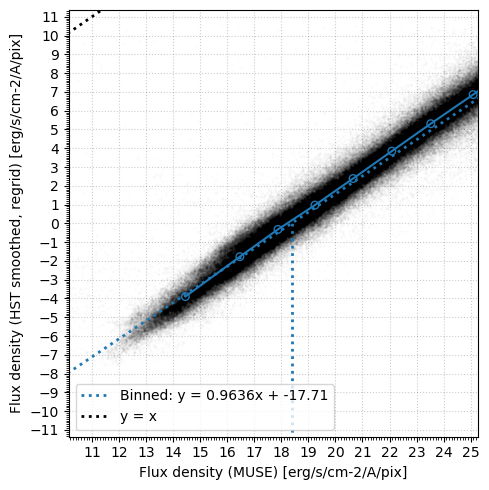

In [24]:
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(1, 1, 1)

xlim = [-10, 60]

ax1.set_xlim(xlim)
ax1.set_ylim(xlim)

data1_ = data1[(data1>xlim[0])&(data1<xlim[1])&(data2>xlim[0])&(data2<xlim[1])]
data2_ = data2[(data1>xlim[0])&(data1<xlim[1])&(data2>xlim[0])&(data2<xlim[1])]

#data
ax1.scatter(data1_, data2_, c='k', alpha=0.01, s=1, rasterized=True)

#bins 
ax1.scatter(mean_values[0], mean_values[1], fc='none', ec='C0', alpha=1, s=30, zorder=5)
ax1.plot(mean_values[0], mean_values[1], c='C0', alpha=1, zorder=5)

# fits 
ax1.plot(x_fit, y_fit_bins, color='C0', linewidth=2, linestyle=':', label=f'Binned: y = {slope_bins:.4f}x + {intercept_bins:.4g}')
ax1.plot(x_fit, x_fit, 'k', linewidth=2, linestyle=':', label=f'y = x')

# Extract the WCS information from the input and template headers
wcs1 = wcs.WCS(hdu1.header)
wcs3 = wcs.WCS(hdu3.header)
pixscale1 = wcs.utils.proj_plane_pixel_area(wcs1.celestial)
pixscale3 = wcs.utils.proj_plane_pixel_area(wcs3.celestial)

pixscale_ratio = (pixscale3 / pixscale1)
offset = (0 - (intercept_bins)) / slope_bins

ax1.plot([offset,offset], [-100,0], color='C0', linewidth=2, linestyle=':')


ax1.set_xlabel('Flux density (MUSE) [erg/s/cm-2/A/pix]')
ax1.set_ylabel('Flux density (HST smoothed, regrid) [erg/s/cm-2/A/pix]')
ax1.legend()
ax1.grid(True, ls=':', color='k', alpha=0.2)

std = np.nanstd(data1_)
ax1.set_xlim([-intercept_bins-std/1.5, -intercept_bins+std/1.5])
ax1.set_ylim([-std, std])

ax1.xaxis.set_minor_locator(MultipleLocator(0.1))
ax1.xaxis.set_major_locator(MultipleLocator(1))
ax1.yaxis.set_minor_locator(MultipleLocator(0.1))
ax1.yaxis.set_major_locator(MultipleLocator(1))

plt.tight_layout()

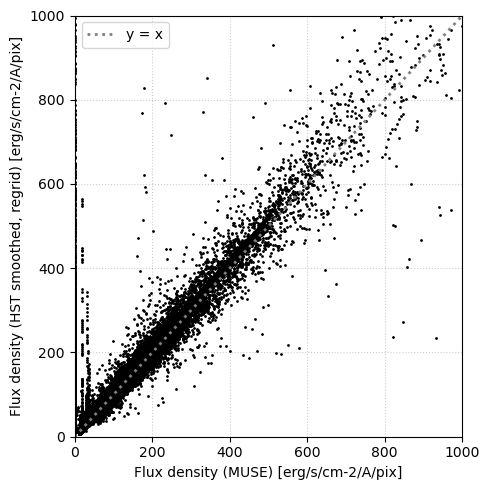

In [13]:
data1 = hdu1.data.copy()
data2 = hdu2.data.copy()

# Extract the WCS information from the input and template headers
wcs1 = wcs.WCS(hdu1.header)
wcs3 = wcs.WCS(hdu3.header)
pixscale1 = wcs.utils.proj_plane_pixel_area(wcs1.celestial)
pixscale3 = wcs.utils.proj_plane_pixel_area(wcs3.celestial)

pixscale_ratio = (pixscale3 / pixscale1)
offset = (0 - (intercept_bins)) / slope_bins
data3 = data2 + offset

fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(1, 1, 1)

#data
ax1.scatter(data1, data3, c='k', alpha=1, s=1, rasterized=True)
ax1.plot(x_fit, x_fit, 'gray', linewidth=2, linestyle=':', label=f'y = x')

ax1.set_xlabel('Flux density (MUSE) [erg/s/cm-2/A/pix]')
ax1.set_ylabel('Flux density (HST smoothed, regrid) [erg/s/cm-2/A/pix]')
ax1.legend()
ax1.grid(True, ls=':', color='k', alpha=0.2)

ax1.set_xlim([0,1e3])
ax1.set_ylim([0,1e3])

# ax1.xaxis.set_minor_locator(MultipleLocator(0.1))
# ax1.xaxis.set_major_locator(MultipleLocator(1))
# ax1.yaxis.set_minor_locator(MultipleLocator(0.1))
# ax1.yaxis.set_major_locator(MultipleLocator(1))

plt.tight_layout()

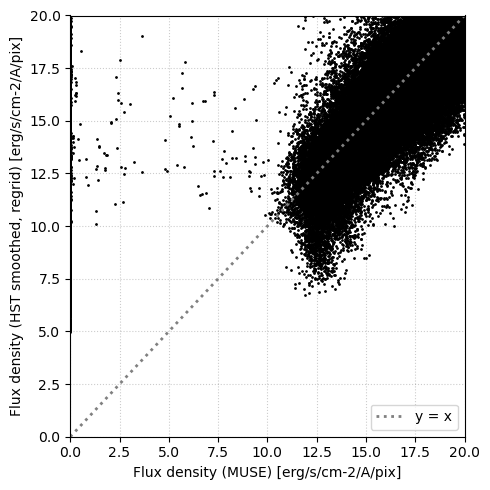

In [14]:
data1 = hdu1.data.copy()
data2 = hdu2.data.copy()

# Extract the WCS information from the input and template headers
wcs1 = wcs.WCS(hdu1.header)
wcs3 = wcs.WCS(hdu3.header)
pixscale1 = wcs.utils.proj_plane_pixel_area(wcs1.celestial)
pixscale3 = wcs.utils.proj_plane_pixel_area(wcs3.celestial)

pixscale_ratio = (pixscale3 / pixscale1)
offset = (0 - (intercept_bins)) / slope_bins
data3 = data2 + offset

fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(1, 1, 1)

#data
ax1.scatter(data1, data3, c='k', alpha=1, s=1, rasterized=True)
ax1.plot(x_fit, x_fit, 'gray', linewidth=2, linestyle=':', label=f'y = x')

ax1.set_xlabel('Flux density (MUSE) [erg/s/cm-2/A/pix]')
ax1.set_ylabel('Flux density (HST smoothed, regrid) [erg/s/cm-2/A/pix]')
ax1.legend()
ax1.grid(True, ls=':', color='k', alpha=0.2)

ax1.set_xlim([0,20])
ax1.set_ylim([0,20])

# ax1.xaxis.set_minor_locator(MultipleLocator(0.1))
# ax1.xaxis.set_major_locator(MultipleLocator(1))
# ax1.yaxis.set_minor_locator(MultipleLocator(0.1))
# ax1.yaxis.set_major_locator(MultipleLocator(1))

plt.tight_layout()